<a href="https://colab.research.google.com/github/youngsiiimba/dashcam-accident-prediction/blob/main/YOLOv3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model
import struct
import cv2

In [2]:
!wget -P weights https://pjreddie.com/media/files/yolov3.weights

--2023-06-15 12:02:40--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘weights/yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   102MB/s    in 2.3s    

2023-06-15 12:02:43 (102 MB/s) - ‘weights/yolov3.weights’ saved [248007048/248007048]



# Define YOLOv3 model

In [3]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0

    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [4]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])

    skip_36 = x

    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])

    skip_61 = x

    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

### Weight reader

In [5]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)

            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance

                    weights = norm_layer.set_weights([gamma, beta, mean, var])

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))

                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

## Make YOLOv3 model

In [6]:
yolov3_model = make_yolov3_model()

In [7]:
# load the model weights
weight_reader = WeightReader('weights/yolov3.weights')

In [8]:
# set the model weights into the model
weight_reader.load_weights(yolov3_model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [9]:
# save the model to a Keras compatible .h5 model file ready for later use.
yolov3_model.save('yolov3-model.h5')



# load yolov3 model
#model = load_model('model.h5')

## Helper functions for making predictions

In [10]:
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [11]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

In [12]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [13]:
def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w

        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]

            if(objectness.all() <= obj_thresh): continue

            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height

            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]

            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

In [14]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)


In [15]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

In [16]:
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

In [17]:
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return

    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [18]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [19]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
      # enumerate all possible labels
      for i in range(len(labels)):
        # check if the threshold for this label is high enough
        if box.classes[i] > thresh:
          v_boxes.append(box)
          v_labels.append(labels[i])
          v_scores.append(box.classes[i]*100)
          # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [20]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
      # show the plot
    pyplot.show()


## Make predictions

In [21]:
!git clone https://github.com/heartkilla/yolo-v3.git

Cloning into 'yolo-v3'...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (139/139), 65.73 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [22]:
image1 = '/content/yolo-v3/data/images/dog.jpg'
image2 = '/content/yolo-v3/data/images/office.jpg'

In [23]:
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/content/yolo-v3/data/images/dog.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

In [24]:
image.size

519168

The output of the model is, in fact, encoded candidate bounding boxes from three different grid sizes, and the boxes are defined the context of anchor boxes, carefully chosen based on an analysis of the size of objects in the MSCOCO dataset.

In [25]:
import numpy as np
# make prediction
yhat = yolov3_model.predict(image)
print(len(yhat))
#arr_yhat = np.array(yhat.copy)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

1/1 [==============================] - 9s 9s/step
3
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [47]:
yhat[0].flatten()

array([-0.16541481,  0.3153256 ,  0.32475203, ..., -3.9620342 ,
       -4.1403227 , -3.6877267 ], dtype=float32)

# Make data for YOLO-LSTM

In [26]:
###access google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!unzip -u -q /content/drive/MyDrive/Dachcam_dataset.zip

In [28]:
train_dir = "/content/videos/training"
test_dir = "/content/videos/testing"

In [29]:
from numpy import expand_dims
from tensorflow.keras.utils import load_img, img_to_array
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [48]:
import cv2
from numpy import expand_dims
from tensorflow.keras.utils import load_img, img_to_array
def coordinates_extraction(video_path):
    coordinates_list = []
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1
    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            # #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (vid_height, vid_width))
            # convert to numpy array
            image = img_to_array(image)
            # scale pixel values to [0, 1]
            image = image.astype('float32')
            image /= 255.0
            # add a dimension so that we have one sample
            image = expand_dims(image, 0)
            predictions = yolov3_model.predict(image)
            coordinates_list.append(predictions[0].flatten())
            count += 1
        else:
            print("Defected frame")
            break
    #return only the first 50 frames, so model makes predict for the next 50 frames
    return coordinates_list

In [31]:
import os
def create_data(input_dir, seq_len, classes):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
          coordinates = coordinates_extraction(os.path.join(os.path.join(input_dir, c), f))
          if len(coordinates) == seq_len:
                X.append(coordinates)
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
          else:
            print("len(coordinates) != seq_len")
            break

    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [32]:
# define the expected input shape for the model
vid_height , vid_width = 416, 416
seq_len = 50
classes = ["negative", "positive"]

#Need to thread this or use multiprocessing to make this faster
import time
start = time.perf_counter()
X_train, y_train = create_data(train_dir, seq_len, classes)
X_test, y_test =  create_data(test_dir, seq_len, classes)
finish = time.perf_counter()
print(f"Finished in {round(finish-start,2)} seconds.")

negative
1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: ignored

In [33]:
!mkdir test

In [34]:
!mkdir negative
!mkdir positive


In [35]:
!mv positive/ test/positive

In [36]:
!mv negative test/negative

In [37]:
#We keep running out run while trying to create the data so we'll use 4 videos to tinker
!cp "/content/videos/testing/negative/000830.mp4" test/negative/000830.mp4
!cp "/content/videos/testing/negative/000831.mp4" test/negative/000831.mp4

!cp "/content/videos/testing/positive/000456.mp4" test/positive/000456.mp4
!cp "/content/videos/testing/positive/000457.mp4" test/positive/000457.mp4

In [49]:
tinker_dir = "test"
X, Y = create_data(tinker_dir, seq_len, classes)

negative
1/1 [==============================] - 0s 28ms/step
positive
1/1 [==============================] - 0s 25ms/step


In [50]:
X.shape

(4, 50, 43095)

In [51]:
X.shape[0]

4

# Make LSTM model

In [67]:
num_samples = X.shape[0]
sequence_length = X.shape[1]
nb_features = X.shape[2]
nb_out = 2
#print(input_shape.shape)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.metrics import fbeta_score
# build the LSTM network
# Feature weights
# LSTM model
LSTM_model = Sequential()

# The first layer
LSTM_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))

# Plus a 20% dropout rate
#LSTM_model.add(Dropout(0.2))

# The second layer
LSTM_model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
#LSTM_model.add(Dropout(0.2))

# # Dense sigmoid layer
LSTM_model.add(Dense(units=nb_out, activation='sigmoid'))
# Dense softmax layer
#LSTM_model.add(Dense(units=nb_out, activation='softmax'))

# # With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



#LSTM_model.compile(optimizer=keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['acc'])

# Verify the architecture
print(LSTM_model.summary())




##Note: I seem to be getting better results with activation set to 'sigmoid' as opposed to 'softmax' and loss set to 'binary_crossentropy' as opposed to 'categorical_crossentropy'



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 100)           17278400  
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 17,308,702
Trainable params: 17,308,702
Non-trainable params: 0
_________________________________________________________________
None


## Train model

In [68]:
import keras
import time


t0 = time.time()
# fit the network
LSTM_history = LSTM_model.fit(X, # Training features
          Y, # Training labels
          epochs=1000,   # We'll stop after 10 epochs
          batch_size=200, #
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          )

print("Training took "+str(time.time() - t0)+" seconds")

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.7052 - acc: 0.3333 - val_loss: 0.9519 - val_acc: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.6638 - acc: 0.6667 - val_loss: 1.0574 - val_acc: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.6312 - acc: 0.6667 - val_loss: 1.1037 - val_acc: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.6342 - acc: 0.6667 - val_loss: 1.1462 - val_acc: 0.0000e+00
Epoch 5/1000
1/1 [==============================] - 0s 86ms/step - loss: 0.6299 - acc: 0.6667 - val_loss: 1.1836 - val_acc: 0.0000e+00
Epoch 6/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.6243 - acc: 0.6667 - val_loss: 1.2124 - val_acc: 0.0000e+00
Epoch 7/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.6179 - acc: 0.6667 - val_loss: 1.2310 - val_acc: 0.0000e+00
Epoch 8/1000
1/1 [==============================] - 0s 80

## Evaluate model

Text(0.5, 1.0, 'Training and validation loss')

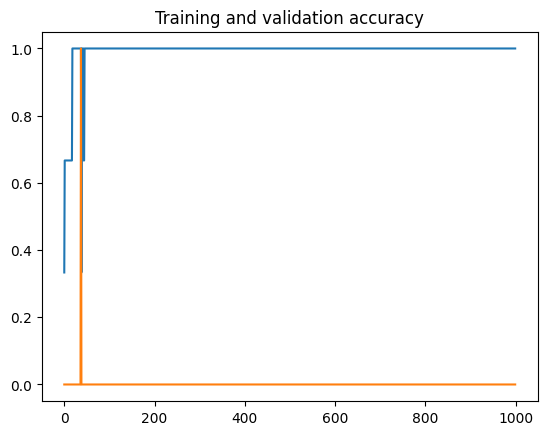

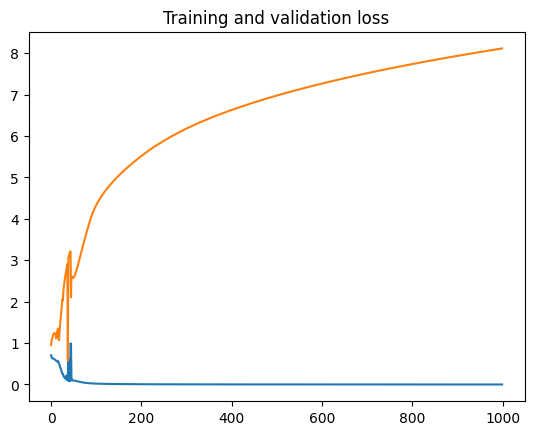

In [69]:
from matplotlib import pyplot as plt
###Evaluate accuracy and loss of model
###Sets for each training epoch
acc = LSTM_history.history['acc']
val_acc = LSTM_history.history['val_acc']

loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

###Get number of epochs
epochs = range(len(acc))

###Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

###Plot training and Validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')